In [1]:
import h5py
import pylab as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
import numpy as np
import os
from scipy.stats import linregress
import seaborn as sns
import tensorflow as tf
import glob
from spacepy import pycdf
import matplotlib as mpl
import warnings
import moms_fast
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

import nnet_evaluate
import utils

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sns.set_style('darkgrid')
%matplotlib inline

This unreleased version of SpacePy is not supported by the SpacePy team.


/mnt/efs/dasilva/anaconda3/envs/compression-cfha/lib/python3.8/site-packages/spacepy/time.py:2365: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
file = '/mnt/efs/dasilva/compression-cfha/data/nnet_models/hidden_layer_exp/4B_dayside.rfr001/moments_stats.hdf'

hdf= h5py.File('/home/ubuntu/data/samples_train_n=50000_nosw.hdf')
phases = list(hdf.keys())

for phase in phases:
    print(phase.ljust(20), hdf[phase]['E'].shape[0])
    
N_EN = 32
N_EN_SHELLS = 2
N_PHI = 32
N_THETA = 16

4A_dusk_flank        49965
4B_dayside           41856
4C_dawn_flank        48888
4D_tail              50265


/tmp/ipykernel_4188/929326086.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf= h5py.File('/home/ubuntu/data/samples_train_n=50000_nosw.hdf')


# Figure 2

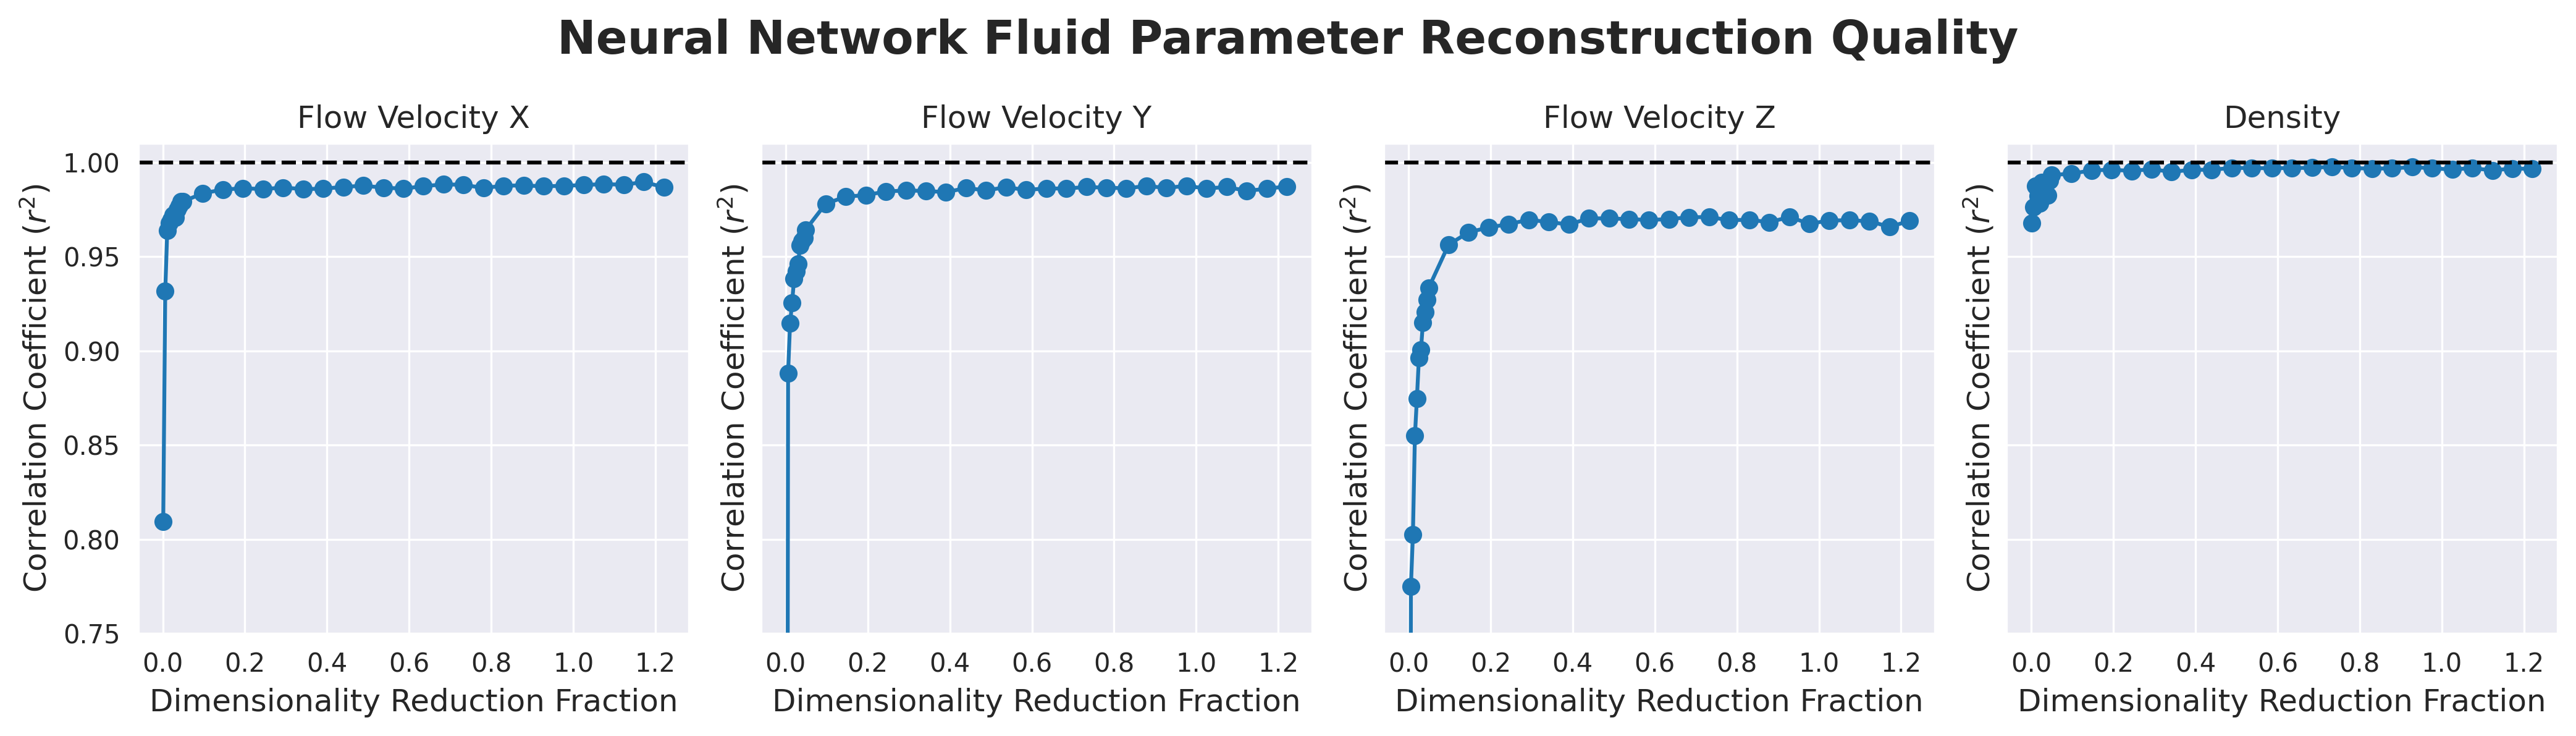

In [3]:
moments = ['vx', 'vy', 'vz', 'n']

fig, axes = plt.subplots(1, 4, sharex='all', sharey='all', figsize=(14, 4), dpi=300)

hdf = h5py.File(file, 'r')
sizes = hdf['sizes'][:]
r2 = {m: hdf[m]['r2'][:] for m in moments}
points_true = {m: hdf[m]['points_true'][:] for m in moments}
points_recon = {m: hdf[m]['points_recon'][:] for m in moments}
hdf.close()

for i, m in enumerate(r2):
    axes[i].plot(sizes/(32*16*2), r2[m], 'o-')

    if m[0]== 'v':
        axes[i].set_title('Flow Velocity ' + m[1].upper()) 
    else:
        axes[i].set_title('Density') 
    axes[i].set_ylabel('Correlation Coefficient ($r^2$)', fontsize=12)
    axes[i].set_xlabel('Dimensionality Reduction Fraction', fontsize=12)

axes[i].set_ylim(0.75, 1.01)
for ax in axes:
    ax.axhline(1, color='black', linestyle='dashed')
    
fig.suptitle('Neural Network Fluid Parameter Reconstruction Quality', fontweight='bold', fontsize=18)
fig.tight_layout()
None

# Figure 3

In [4]:
E = np.array([2.160000e+00, 3.910000e+00, 7.070000e+00, 1.093000e+01,
       1.424000e+01, 1.854000e+01, 2.414000e+01, 3.144000e+01,
       4.094000e+01, 5.332000e+01, 6.944000e+01, 9.043000e+01,
       1.177700e+02, 1.533600e+02, 1.997200e+02, 2.601000e+02,
       3.387200e+02, 4.411100e+02, 5.744500e+02, 7.481000e+02,
       9.742300e+02, 1.268720e+03, 1.652240e+03, 2.151680e+03,
       2.802100e+03, 3.649120e+03, 4.752190e+03, 6.188690e+03,
       8.059430e+03, 1.049565e+04, 1.366831e+04, 1.780000e+04],
      dtype=np.float32)

def get_data(cdf_filename):
    cdf = pycdf.CDF(cdf_filename)

    dist = cdf['mms1_dis_dist_brst'][:]
    dist_err = cdf['mms1_dis_disterr_brst'][:]
    epoch = cdf['Epoch'][:]
    ntime = epoch.size
    counts = np.zeros((ntime, N_PHI, N_THETA, N_PHI))

    for i in range(ntime):
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            tmp_counts = np.square(dist[i] / dist_err[i])
        tmp_counts[np.isnan(tmp_counts)] = 0
        tmp_counts = np.rint(tmp_counts)
        counts[i] = tmp_counts

    cdf.close()

    return epoch, counts, ntime

/tmp/ipykernel_4188/2621031807.py:23: RuntimeWarning: invalid value encountered in true_divide
  rel_error = 100 * (a - b)/a
/tmp/ipykernel_4188/2621031807.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[i].pcolor(epoch, E, (counts).mean(axis=((1, 2))).T, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')
/tmp/ipykernel_4188/2621031807.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[i].pcolor(epoch, E, (counts_recon).mean(axis=(

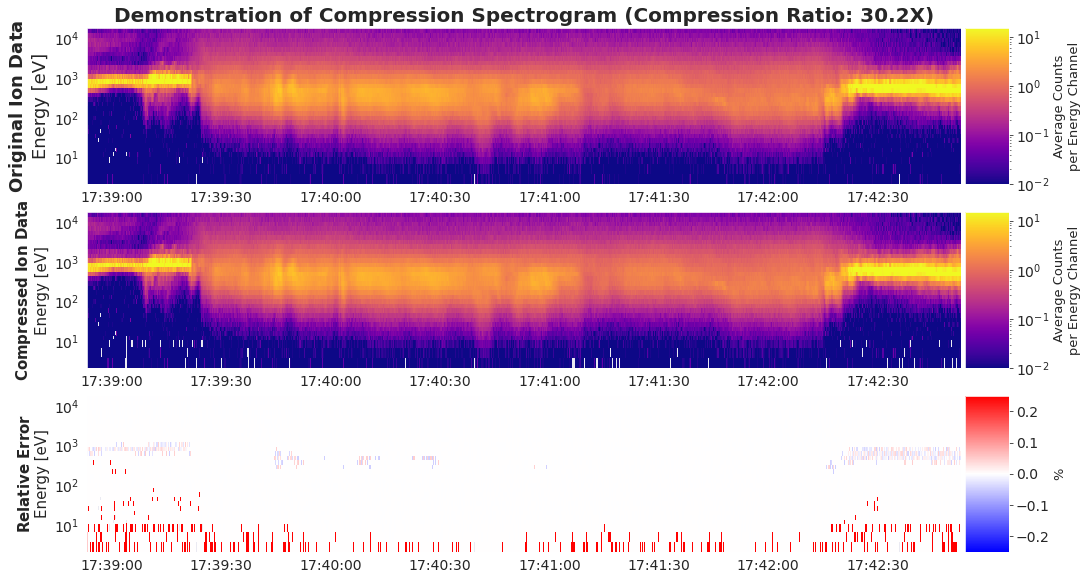

In [5]:
hdf_filename = 'example.h5'
cdf_filename = 'mms1_example_data.cdf'
gpc_filename = hdf_filename.replace('.h5', '.gpc')
gpc_filename = gpc_filename.replace('.hdf5', '.gpc')
epoch, counts, ntime = get_data(cdf_filename)

hdf = h5py.File(hdf_filename, 'r')
counts_recon = hdf['counts'][:]
hdf.close()

cmpr_ratio =  (32 * 16 * 32 * 16 * epoch.size) / (os.path.getsize(gpc_filename) * 8)
file_size = os.path.getsize(gpc_filename) / epoch.size
vars = ['Strue', 'Srecon', 'Srel']
fig, axes = plt.subplots(len(vars), 1, figsize=(15, 2.7*len(vars)))

Escale = np.zeros((32, counts.shape[0]))
for k in range(Escale.shape[1]):
    Escale[:, k] = E
caxes = []

a = (counts).mean(axis=((1, 2))).T
b = (counts_recon).mean(axis=((1, 2))).T
rel_error = 100 * (a - b)/a
    
for i, var in enumerate(vars):
    vmin = .01
    vmax = 15
    if var == 'Strue':
        im = axes[i].pcolor(epoch, E, (counts).mean(axis=((1, 2))).T, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')
        axes[i].set_ylabel('$\\bf{Original~Ion~Data}$\nEnergy [eV]', fontsize=18)
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical').set_label('Average Counts\nper Energy Channel', fontsize=13)
    elif var == 'Srecon':
        im = axes[i].pcolor(epoch, E, (counts_recon).mean(axis=((1, 2))).T, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')
        axes[i].set_ylabel('$\\bf{Compressed~Ion~Data}$\nEnergy [eV]', fontsize=15)
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical').set_label('Average Counts\nper Energy Channel', fontsize=13)
    elif var == 'Srel':
        im = axes[i].pcolor(epoch, E, rel_error, vmin=-.25, vmax=.25, cmap='bwr')
        axes[i].set_ylabel('$\\bf{Relative~Error}$\nEnergy [eV]', fontsize=15)
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical').set_label('%', fontsize=13)

    axes[i].set_yscale('log')
    caxes.append(cax)

axes[0].set_title(f'Demonstration of Compression Spectrogram (Compression Ratio: {cmpr_ratio:.1f}X)', fontweight='bold', fontsize=20)
fig.tight_layout()

for ax in axes.tolist() + caxes:
    ax.tick_params(axis='both', which='major', labelsize=14)

# Moments Plot -- Not Published

In [6]:
test_data = nnet_evaluate.load_test_data('4B_dayside')
f1ct = utils.get_f1ct({'4B_dayside': test_data}, ['4B_dayside'])

/tmp/ipykernel_4188/3251389564.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


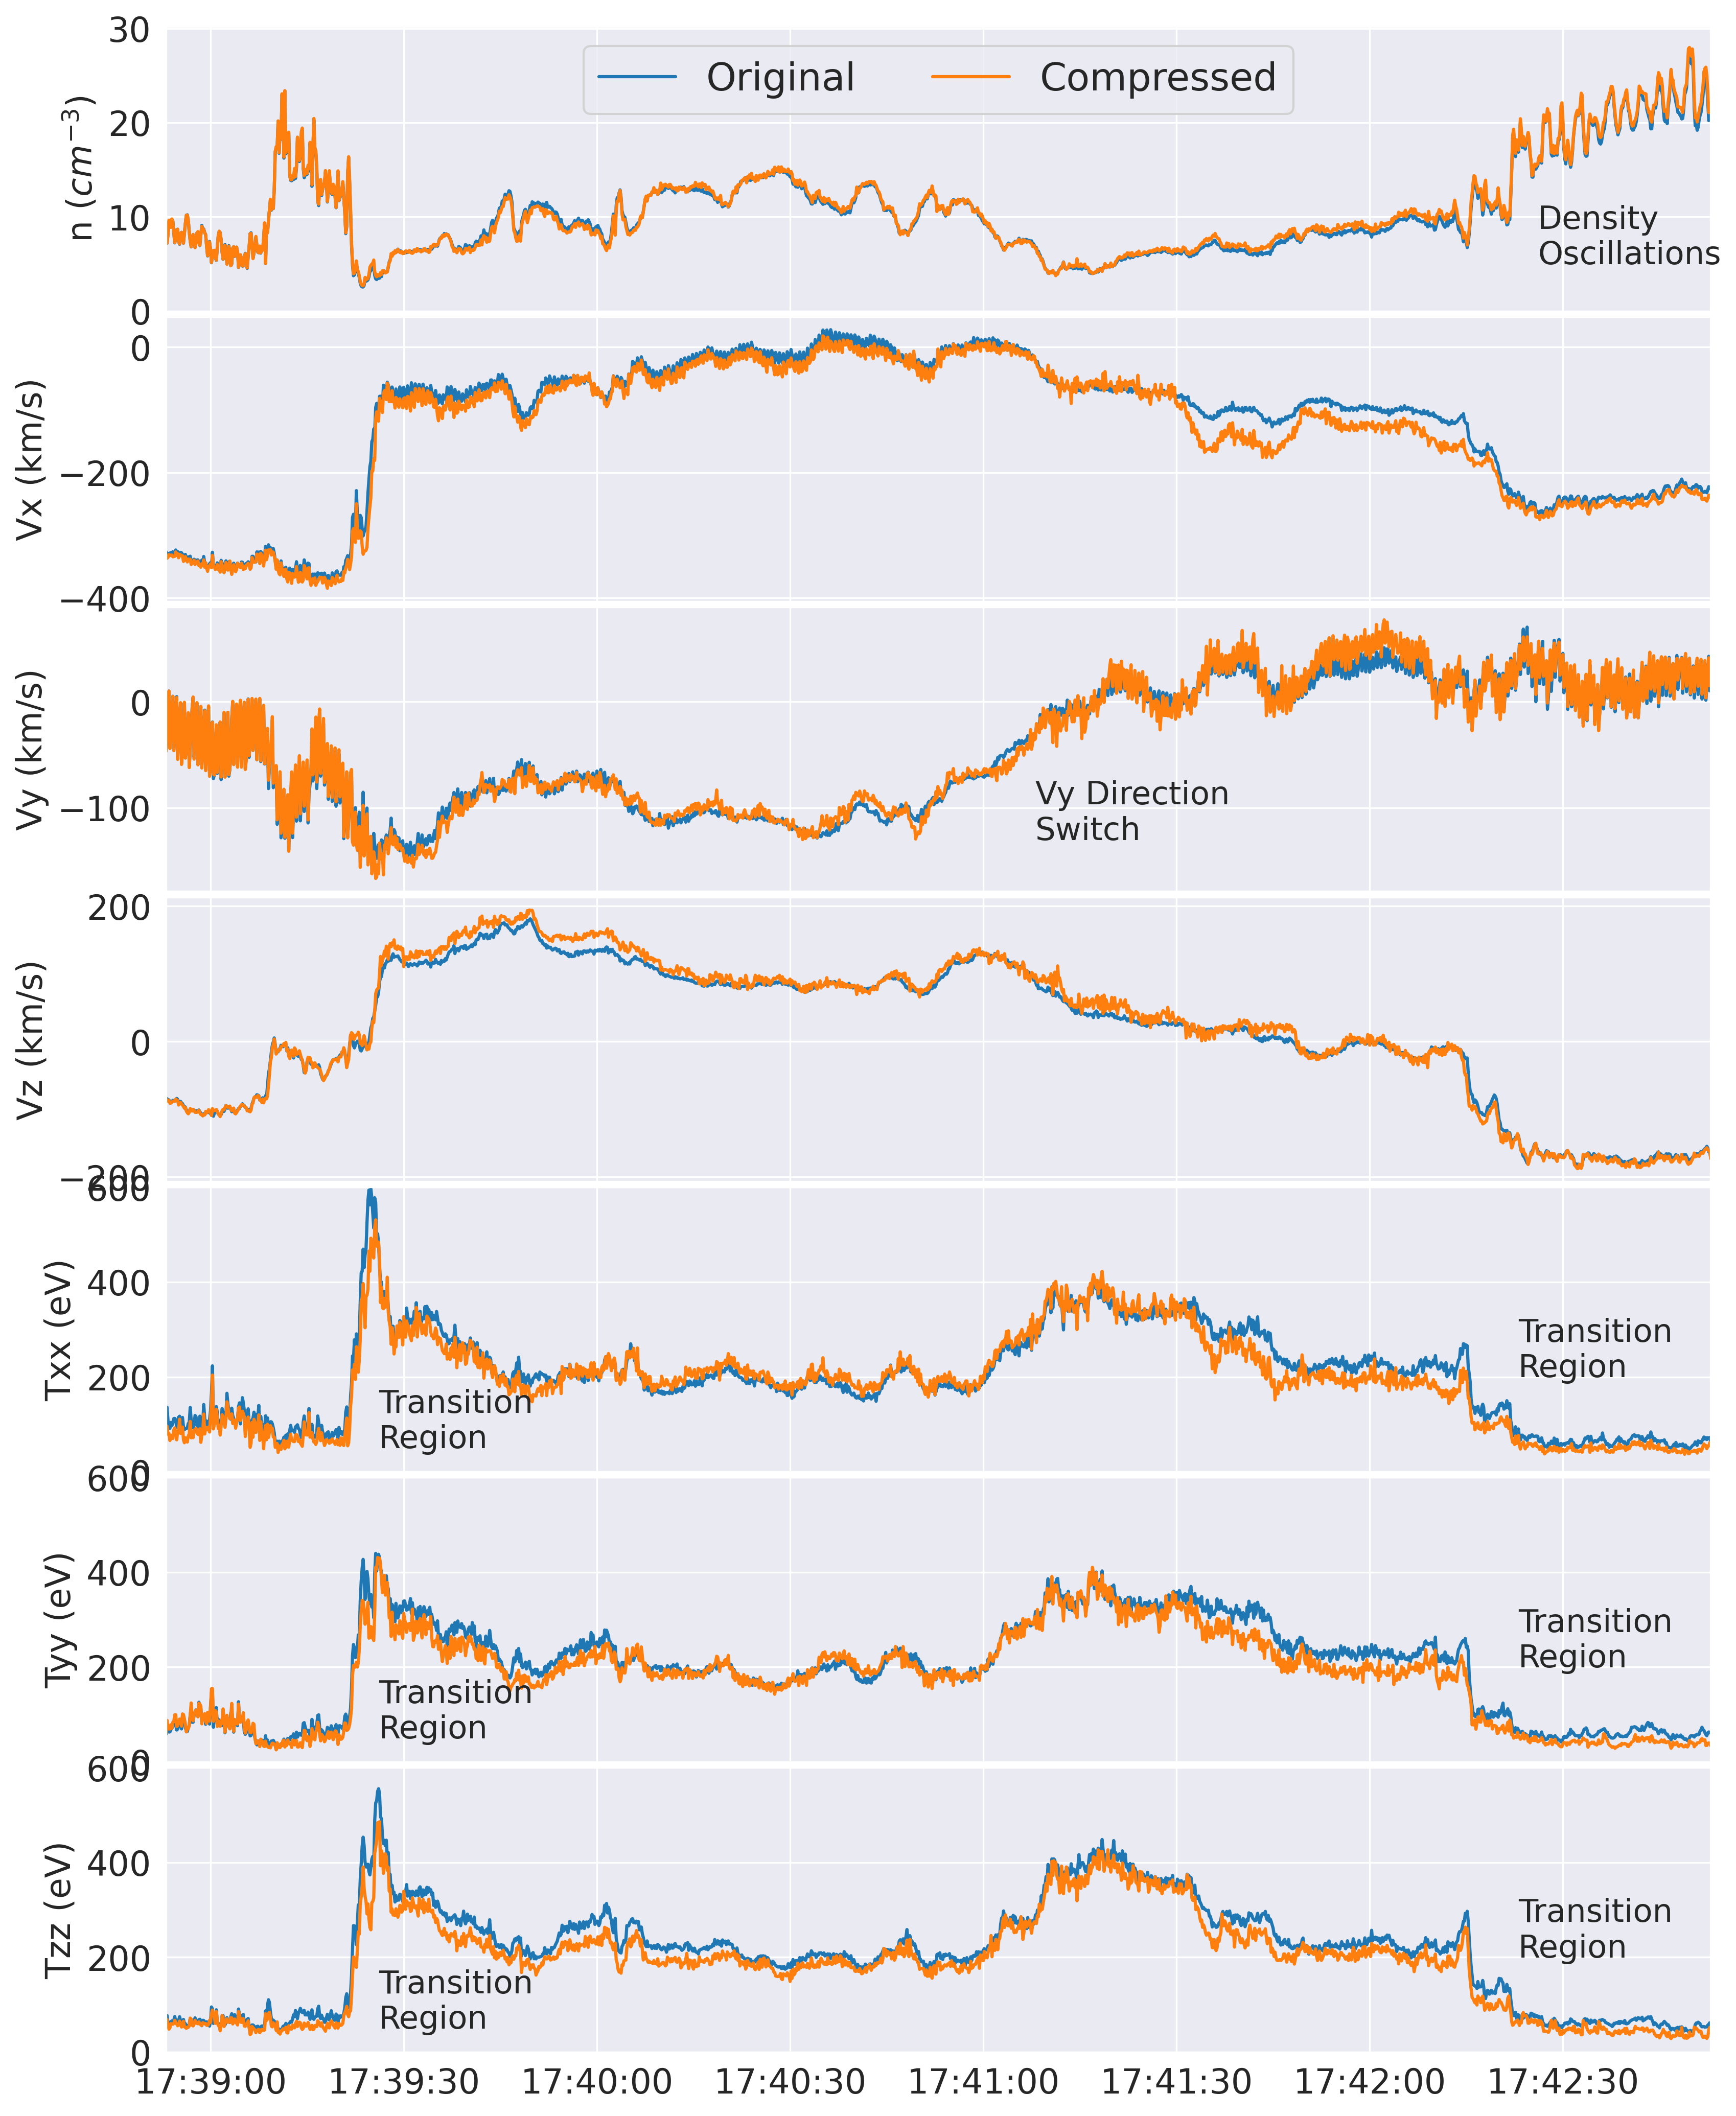

In [22]:
moms_true = [moms_fast.fast_moments(f1ct * c) for c in counts]
moms_recon = [moms_fast.fast_moments(f1ct * c) for c in counts_recon]

vars = ['n', 'vx', 'vy', 'vz', 'txx', 'tyy', 'tzz']
fig, axes = plt.subplots(len(vars), 1, figsize=(13, 2.5*len(vars)), sharex='all', dpi=300, gridspec_kw = {'wspace':0, 'hspace':0.02})

for i, var in enumerate(vars):
    axes[i].plot(epoch, [d[var] for d in moms_true], label=f'Original')
    axes[i].plot(epoch, [d[var] for d in moms_recon], label=f'Compressed')
        
    if i == 0:
        axes[i].legend(ncol=2, fontsize=18)
    if var == 'n':
        axes[i].set_ylim([0, 1.1 * np.max([d[var] for d in moms_true])])
        axes[i].set_ylabel('n ($cm^{-3}$)', fontsize=16)
    elif var[0] == 'v':
        axes[i].set_ylabel(f'{var.capitalize()} (km/s)', fontsize=16)
    elif var[0] == 't':
        axes[i].set_ylabel(f'{var.capitalize()} (eV)', fontsize=16)
        axes[i].set_ylim(0, 600)
    axes[i].set_xlim(epoch[0], epoch[-1])
    
#axes[0].set_title(f'Demonstration of Compression Moments (Compression Ratio: {cmpr_ratio:.1f}X)', fontweight='bold', fontsize=20)

for ax in axes.tolist():
    ax.tick_params(axis='both', which='major', labelsize=16)

axes[0].text(epoch[1420], 5, 'Density\nOscillations', fontsize=15)
axes[2].text(epoch[900], -130, 'Vy Direction\nSwitch', fontsize=15)
axes[4].text(epoch[220], 50, 'Transition\nRegion', fontsize=15)
axes[5].text(epoch[220], 50, 'Transition\nRegion', fontsize=15)
axes[6].text(epoch[220], 50, 'Transition\nRegion', fontsize=15)
axes[4].text(epoch[1400], 200, 'Transition\nRegion', fontsize=15)
axes[5].text(epoch[1400], 200, 'Transition\nRegion', fontsize=15)
axes[6].text(epoch[1400], 200, 'Transition\nRegion', fontsize=15)

fig.tight_layout()

# Compression Ratio NeurIPS Poster Plot

/tmp/ipykernel_4188/1789933044.py:32: RuntimeWarning: invalid value encountered in true_divide
  rel_error = 100 * (a - b)/a
/tmp/ipykernel_4188/1789933044.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[i].pcolor(epoch, E, (counts).mean(axis=((1, 2))).T, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')
/tmp/ipykernel_4188/1789933044.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[i].pcolor(epoch, E, (counts_recon).mean(axis=(

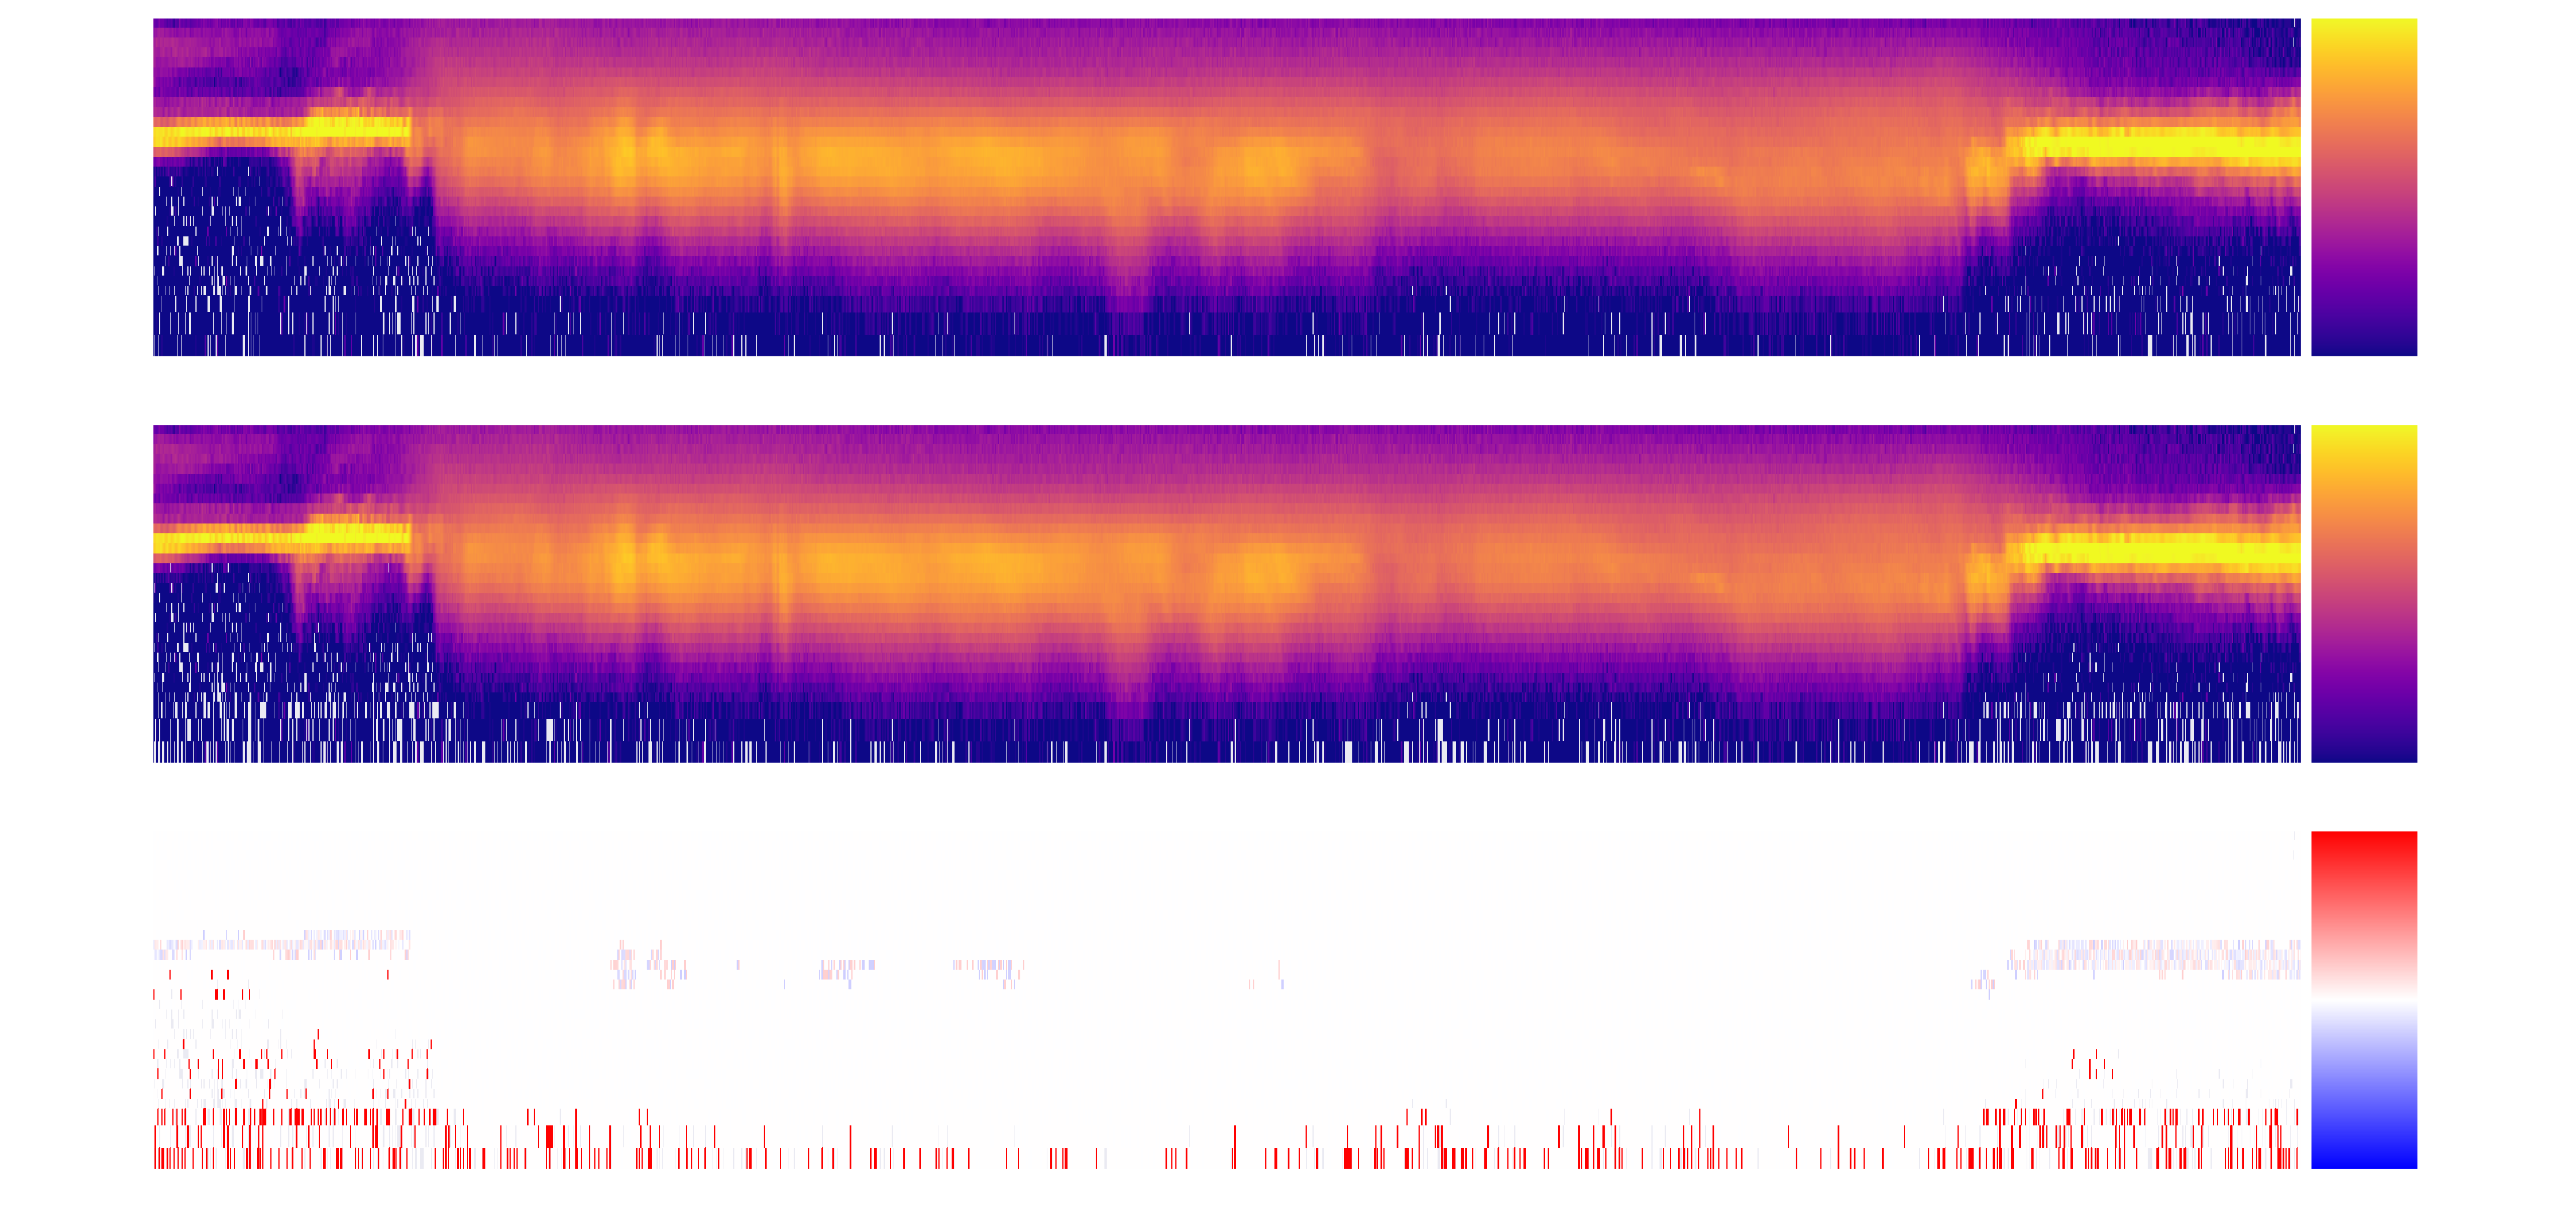

In [8]:
context = {
    "ytick.color" : "w",
    "xtick.color" : "w",
    "axes.labelcolor" : "w",
    "axes.edgecolor" : "w"
}

with  mpl.rc_context(context):
    hdf_filename = 'example.h5'
    cdf_filename = 'mms1_example_data.cdf'
    gpc_filename = hdf_filename.replace('.h5', '.gpc')
    gpc_filename = gpc_filename.replace('.hdf5', '.gpc')
    epoch, counts, ntime = get_data(cdf_filename)

    epoch, counts, ntime = get_data(cdf_filename)

    hdf = h5py.File(hdf_filename, 'r')
    counts_recon = hdf['counts'][:]
    hdf.close()

    cmpr_ratio =  (32 * 16 * 32 * 16 * epoch.size) / (os.path.getsize(gpc_filename) * 8)
    file_size = os.path.getsize(gpc_filename) / epoch.size
    vars = ['Strue', 'Srecon', 'Srel']
    fig, axes = plt.subplots(len(vars), 1, figsize=(15, 2.4*len(vars)), dpi=300)

    Escale = np.zeros((32, counts.shape[0]))
    for k in range(Escale.shape[1]):
        Escale[:, k] = E

    a = (counts).mean(axis=((1, 2))).T
    b = (counts_recon).mean(axis=((1, 2))).T
    rel_error = 100 * (a - b)/a

    for i, var in enumerate(vars):
        vmin = .01
        vmax = 15
        if var == 'Strue':
            im = axes[i].pcolor(epoch, E, (counts).mean(axis=((1, 2))).T, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')
            axes[i].set_ylabel('$\\bf{Original~Ion~Data}$\nEnergy [eV]', fontsize=13)
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical').set_label('Average Counts\nper Energy Channel', fontsize=12)
        elif var == 'Srecon':
            im = axes[i].pcolor(epoch, E, (counts_recon).mean(axis=((1, 2))).T, norm=LogNorm(vmin=vmin, vmax=vmax), cmap='plasma')
            axes[i].set_ylabel('$\\bf{Compressed~Ion~Data}$\nEnergy [eV]', fontsize=13)
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical').set_label('Average Counts\nper Energy Channel', fontsize=12)
        elif var == 'Srel':
            im = axes[i].pcolor(epoch, E, rel_error, vmin=-.25, vmax=.25, cmap='bwr')
            axes[i].set_ylabel('$\\bf{Relative~Error}$\nEnergy [eV]', fontsize=13)
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical').set_label('%', fontsize=12)

        axes[i].set_yscale('log')
        caxes.append(cax)
    #axes[0].set_title(f'Demonstration of Compression (Compression Ratio: {cmpr_ratio:.1f}X)', fontweight='bold', fontsize=20, color='white')
    fig.tight_layout()